# オートエンコーダ

## オートエンコーダとは

　自己符号化器とも呼ばれます。

　可視層と隠れ層の2層からなるネットワークです。入力層と出力層が同じ層であるニューラルネットワークと考えることもできます。

<img src="fig/autoencoder.png" width="70%" alt="autoencoder">

　入力と出力が同じになるように学習すれば、「教師なし学習」ができます。
 
　入力から隠れ層へのデータ処理をエンコード、隠れ層から出力へのデータ処理をデコードと呼びます。可視層より隠れ層のほうがユニット数が少ないので、入力をエンコードにより圧縮して、デコードにより復元して出力するように見えます。
すなわち学習により入力から本質的な特徴量だけを抽出していることになります。
 

### 積層オートエンコーダ

　あるオートエンコーダの隠れ層を別のオートエンコーダの可視層になるよう、オートエンコーダを多段につないだネットワークを積層オートエンコーダと呼びます。
 
　積層オートエンコーダでは、各オートエンコーダを1段目から順に個別に学習していくことが可能です。このような手法を事前学習と呼びます。また事前学習で個々のオートエンコーダの学習が済んだ後、最終的にネットワーク全体をつないでのパラメータの微調整が必要です。これをファインチューニングと呼びます。

## オートエンコーダを使った画像圧縮

　オートエンコーダは、入力データの特徴量を抽出し、それを使って入力とほぼ同じ出力を作っているとみなすことができます。

　そこで画像のように、入出力が大体同じになればよいデータでは、オートエンコーダの隠れ層の出力は元の画像を圧縮したデータとも言えます。

　パラメータをうまく設定できれば、JPEG など通常の画像圧縮よりも高圧縮率のデータが得られる可能性があります。

In [1]:
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist


### MNIST で試行

In [3]:
(x_train, _), (_, _) = mnist.load_data()

x_train = x_train.reshape(-1,784) / 255 

### モデル作成

In [7]:
# 784(=28x28)個のデータ を 16個にまとめる(圧縮率約 98 %)
org_size = 28*28
enc_dim = 16

# 後でエンコーダ、デコーダを個々に動作させたいので、それぞれ別のモデルにしておく
# エンコーダ部
encoder = Sequential()
encoder.add(Dense(input_shape=(org_size,), units=enc_dim, activation='relu'))

# デコーダ部
decoder = Sequential()
decoder.add(Dense(input_shape=(enc_dim,), units=org_size, activation='sigmoid'))

# エンコーダとデコーダを並べて一つのモデルにする。
model = Sequential()
model.add(encoder)
model.add(decoder)

model.compile(
    optimizer='adam', 
    loss='mse')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 16)                12560     
                                                                 
 sequential_4 (Sequential)   (None, 784)               13328     
                                                                 
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________


### 学習
モデルの入力と出力を同じにして、オートエンコーダとして学習を行います。

In [8]:
history = model.fit(
    x_train,
    x_train,
    epochs=15,
    batch_size=256,
    shuffle=True,
    validation_split=0.2)

Epoch 1/15
188/188 [==============================] - 1s 5ms/step - loss: 0.0873 - val_loss: 0.0552
Epoch 2/15
188/188 [==============================] - 1s 4ms/step - loss: 0.0485 - val_loss: 0.0427
Epoch 3/15
188/188 [==============================] - 1s 4ms/step - loss: 0.0395 - val_loss: 0.0362
Epoch 4/15
188/188 [==============================] - 1s 4ms/step - loss: 0.0342 - val_loss: 0.0319
Epoch 5/15
188/188 [==============================] - 1s 5ms/step - loss: 0.0306 - val_loss: 0.0291
Epoch 6/15
188/188 [==============================] - 1s 4ms/step - loss: 0.0283 - val_loss: 0.0273
Epoch 7/15
188/188 [==============================] - 1s 4ms/step - loss: 0.0268 - val_loss: 0.0262
Epoch 8/15
188/188 [==============================] - 1s 5ms/step - loss: 0.0259 - val_loss: 0.0255
Epoch 9/15
188/188 [==============================] - 1s 4ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 10/15
188/188 [==============================] - 1s 4ms/step - loss: 0.0247 - val_loss: 0.0243

### 画像で確認

オートエンコーダの隠れ層の出力が、伸長可能な状態で圧縮されているか、画像で確認してみます。

上から「元画像(28x28)」、「圧縮後(4x4)」、「デコードした結果(28x28)」


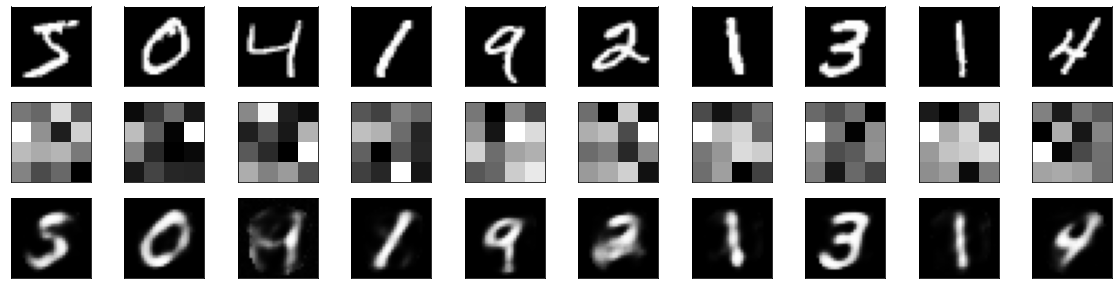

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
def disp_fig(ax, fig):
    ax.imshow(fig, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
#　最初の 10 個で確認
n = 10 

print('上から「元画像(28x28)」、「圧縮後(4x4)」、「デコードした結果(28x28)」')
for i in range(n):
    # 元の画像
    ax = plt.subplot(3, n, i + 1)
    disp_fig(ax, x_train[i].reshape(28, 28) * 255)
    
    # エンコーダの出力を取り出す
    ax = plt.subplot(3, n, n + i + 1)
    enc = encoder.predict(x_train[i].reshape(-1, 28*28))
    # 画像ではないが、とりあえず4x4 の画像として表示してみる。
    disp_fig(ax, enc.reshape(4, 4))

    # エンコーダの出力からデコードする
    ax = plt.subplot(3, n, n*2 + i + 1)
    dec = decoder.predict(enc)
    disp_fig(ax, dec.reshape(28, 28) * 255)

plt.show()

### 学習の経過

<AxesSubplot:>

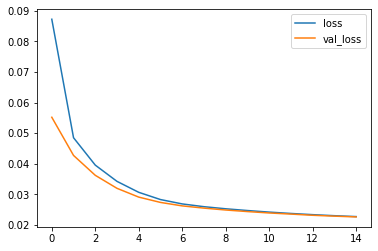

In [10]:
import pandas as pd

pd.DataFrame({'loss': history.history['loss'],
              'val_loss': history.history['val_loss']}).plot()

## オートエンコーダを使った画像生成

　オートエンコーダの例として画像生成を行ってみます。

　まずMNIST から特定の数字(8)だけを使ってオートエンコーダを学習させます。できあがったモデルにMNISTの全体を入力して、出力される画像を確認してみます。

In [11]:
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist, fashion_mnist

%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
(x_train, y_train), (_, _) = mnist.load_data()

x_train = x_train.reshape(-1,784) / 255 

In [14]:
# 答えが '8' の画像だけ抽出
x_train_src = x_train[y_train==8]
print(len(x_train_src))

5851


### モデル作成

隠れ層1層、入出力の次元数が同じであるニューラルネットワークを作ります。

In [15]:
org_size = 28*28
enc_dim = 16

model = Sequential()
model.add(Dense(input_shape=(org_size,), units=enc_dim, activation='relu'))
model.add(Dense(units=org_size, activation='sigmoid'))

model.compile(
    optimizer='adam', 
    loss='mse')

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                12560     
                                                                 
 dense_5 (Dense)             (None, 784)               13328     
                                                                 
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________


### 学習
モデルの入力と出力を同じにして、オートエンコーダとして学習を行います。

入出力には、抽出した数字8の画像だけを与えます。

In [16]:
history = model.fit(
    x_train_src,
    x_train_src,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_split=0.2)

Epoch 1/15
37/37 [==============================] - 1s 10ms/step - loss: 0.1544 - val_loss: 0.0692
Epoch 2/15
37/37 [==============================] - 0s 4ms/step - loss: 0.0625 - val_loss: 0.0573
Epoch 3/15
37/37 [==============================] - 0s 5ms/step - loss: 0.0584 - val_loss: 0.0549
Epoch 4/15
37/37 [==============================] - 0s 4ms/step - loss: 0.0550 - val_loss: 0.0516
Epoch 5/15
37/37 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0487
Epoch 6/15
37/37 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0464
Epoch 7/15
37/37 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0444
Epoch 8/15
37/37 [==============================] - 0s 4ms/step - loss: 0.0442 - val_loss: 0.0426
Epoch 9/15
37/37 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0409
Epoch 10/15
37/37 [==============================] - 0s 3ms/step - loss: 0.0408 - val_loss: 0.0395
Epoch 11/15
37/37 

### 画像生成
できあがったモデルに、元のMNISTデータを入力します。

入力した数字と学習した数字8が合成された出力が得られます。

上「元画像(28x28)」、下「生成画像(28x28)」


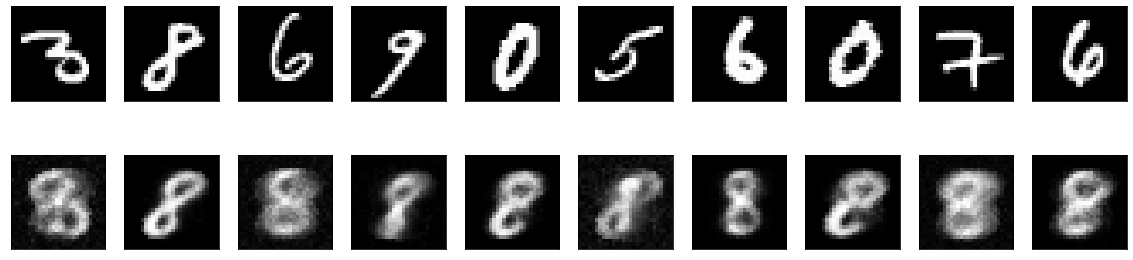

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
def disp_fig2(ax, fig):
    ax.imshow(fig.reshape(28, 28) * 255, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# 画像作成
created = model.predict(x_train)
    
# (start)〜(start+n-1) 個目のデータで確認
start = 30
n = 10 

print('上「元画像(28x28)」、下「生成画像(28x28)」')
for i in range(n):
    # 元の画像
    ax = plt.subplot(2, n, i + 1)
    disp_fig2(ax, x_train[start + i])

    # 作成画像
    ax = plt.subplot(2, n, n + i + 1)
    disp_fig2(ax, created[start + i])

    
plt.show()

### 異常検知
　入力した画像が8であれば、入力画像と生成画像はよく似た画像になりますが、逆に入力画像と生成画像に大きな差があれば、入力画像は8でないと考えられます。

　このように入力画像と生成画像の差を見ることで、入力画像の異常検知が可能です。

1 0.065305
2 0.026719
3 0.069115
4 0.042742
5 0.04788
6 0.058305
7 0.059166
8 0.060999
9 0.073521
10 0.058039


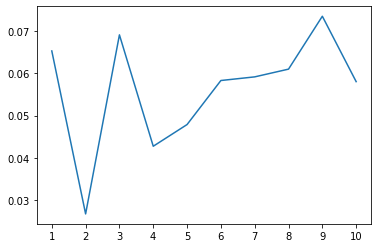

In [29]:
# 入出力画像の差分の二乗平均を計算
# 入力画像が 8 の場合が最小値になるはず
mean_sqare_root = []
for i in range(n):
    idx = start + i
    org = x_train[idx]
    crt = created[idx]
    
    msqr = ((crt - org)**2).mean()
    mean_sqare_root.append(msqr)
    print(i+1, f"{msqr:.5}")

# グラフ化
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(1, 11), mean_sqare_root)
plt.xticks(range(1, 11))
plt.show()
